In [1]:
import torch
from torch import nn
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Make 1000 samples
n_samples = 1000

# Create Circle
X, y = make_circles(n_samples, 
                    noise=0.03,
                    random_state=42)
len(X), len(y)

(1000, 1000)

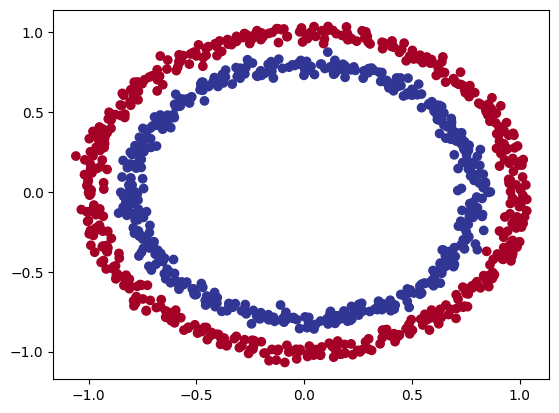

In [3]:
# Visualize data
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
           cmap=plt.cm.RdYlBu)
plt.show()

In [4]:
print(f"First 5 data of X:\n {X[:5]}")
print(f"First 5 data of y:\n {y[:5]}")

First 5 data of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 data of y:
 [1 1 1 1 0]


In [5]:
# Turn data into Tensor
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

type(X), type(y), X.dtype, y.dtype

(torch.Tensor, torch.Tensor, torch.float32, torch.float32)

In [6]:
# Split data into train & test

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Total Sample: {n_samples}")
print(f"Train & Test data: {len(X_train), len(X_test), len(y_train), len(y_test)}")



Total Sample: 1000
Train & Test data: (800, 200, 800, 200)


In [7]:
# Make device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [8]:
!nvidia-smi

Tue Jan 28 14:35:03 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050 Ti     Off | 00000000:01:00.0  On |                  N/A |
| N/A   38C    P8              N/A /  16W |     49MiB /  4096MiB |      8%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [9]:
# Setup the accuracy function

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

In [10]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if it's not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


In [18]:
## Build Model with non-linearity

class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer1 = nn.Linear(in_features=2, out_features=10)
        self.linear_layer2 = nn.Linear(in_features=10, out_features=10)
        self.linear_layer3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.linear_layer3(self.relu(self.linear_layer2(self.relu(self.linear_layer1(x)))))
    

model_1 = CircleModelV1().to(device)
model_1.state_dict()

OrderedDict([('linear_layer1.weight',
              tensor([[ 0.0429,  0.1572],
                      [-0.6929,  0.2717],
                      [-0.2717,  0.3992],
                      [ 0.0934, -0.3609],
                      [-0.1275, -0.2847],
                      [ 0.5275, -0.5391],
                      [ 0.1569,  0.2834],
                      [-0.6700, -0.3235],
                      [ 0.0071, -0.0075],
                      [ 0.3420,  0.1378]], device='cuda:0')),
             ('linear_layer1.bias',
              tensor([ 0.6666, -0.4879, -0.5362,  0.3283, -0.3320,  0.4769,  0.0832, -0.2228,
                      -0.0762, -0.0701], device='cuda:0')),
             ('linear_layer2.weight',
              tensor([[ 0.1877,  0.1911, -0.2046, -0.1767, -0.0657, -0.2347,  0.1393, -0.3028,
                        0.1256,  0.1792],
                      [ 0.2153, -0.0368,  0.0251,  0.1891,  0.1148,  0.0977,  0.1691,  0.0430,
                       -0.0719,  0.0966],
                    

In [19]:
# Loss & Optimizer

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)


## 3. Train the model

So we have to do following steps:

    - set the epochs
    - start the train-loop untill epochs
    - start to model train
    - then go forward pass pass
    - calculate the train-loss
    - set the optimizer zero grad
    - take the loss in backward
    - now time to optimizer to step
    - Now start with Testing
    - make the model in eval mode
    - now go forward with inference mode
    - then try to calculate test loss
    - finally see the full report


In [20]:
# Set the gpu random seed
torch.cuda.manual_seed(42)

# Set the epochs range
epochs = 1000


# Transfer all the data into GPU as our model in GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# strat the training loop in range epochs
for epoch in range(epochs):

    # Model in train mode
    model_1.train()
    
    # 1. Forward Pass
    y_logits = model_1(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # 2. Calculate the loss/acc
    train_loss = loss_fn(y_logits, y_train)
    train_acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss to backward -> Backpropagation
    train_loss.backward()

    # 5. Optimizer step -> Gradient Descent
    optimizer.step()


    ### Testing

    # Model in Eval
    model_1.eval()

    # froward pass with inference mode
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        # Calculate Test loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_preds)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.2f}% | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%")
    


Epoch: 0 | Train Loss: 0.69561 | Train Accuracy: 50.00% | Test Loss: 0.69674 | Test Accuracy: 50.00%
Epoch: 10 | Train Loss: 0.69359 | Train Accuracy: 50.00% | Test Loss: 0.69498 | Test Accuracy: 50.00%
Epoch: 20 | Train Loss: 0.69240 | Train Accuracy: 50.00% | Test Loss: 0.69409 | Test Accuracy: 50.00%
Epoch: 30 | Train Loss: 0.69189 | Train Accuracy: 50.00% | Test Loss: 0.69372 | Test Accuracy: 49.00%
Epoch: 40 | Train Loss: 0.69154 | Train Accuracy: 46.12% | Test Loss: 0.69351 | Test Accuracy: 49.00%
Epoch: 50 | Train Loss: 0.69126 | Train Accuracy: 51.00% | Test Loss: 0.69336 | Test Accuracy: 47.00%
Epoch: 60 | Train Loss: 0.69102 | Train Accuracy: 50.88% | Test Loss: 0.69322 | Test Accuracy: 46.00%
Epoch: 70 | Train Loss: 0.69079 | Train Accuracy: 51.38% | Test Loss: 0.69308 | Test Accuracy: 47.00%
Epoch: 80 | Train Loss: 0.69041 | Train Accuracy: 51.50% | Test Loss: 0.69283 | Test Accuracy: 47.00%
Epoch: 90 | Train Loss: 0.69014 | Train Accuracy: 52.25% | Test Loss: 0.69269 | Tes

In [24]:
# Makes predictions
model_1.eval()
# print(X_test)
with torch.inference_mode():
  y_preds =  torch.round(torch.sigmoid(model_1(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

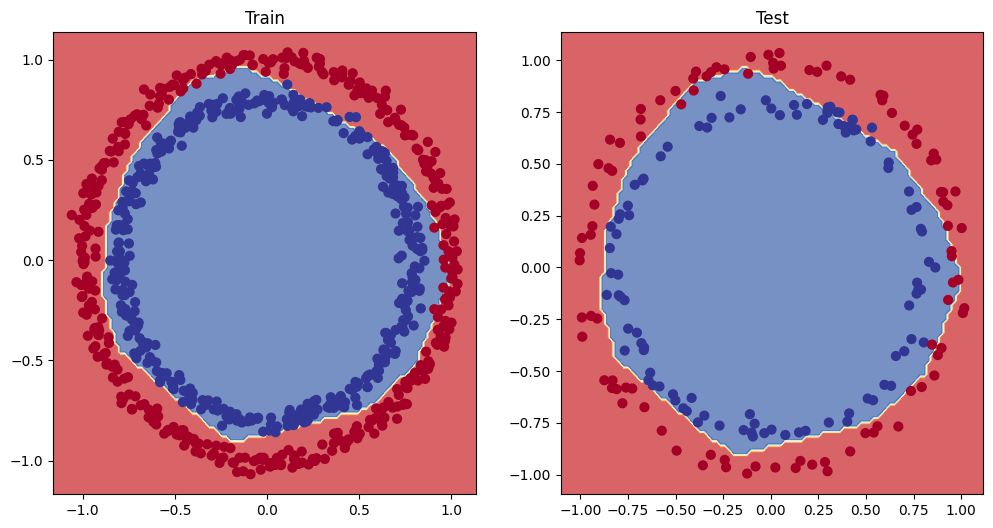

In [14]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test) 

In [ ]:
# Make a pandas Dataframe
circle_df = pd.DataFrame({'X1': X[:,0],
                          'X2': X[:,1],
                          'labels': y})

circle_df.head(10)


### 1.1 Check Input & Output Shape

In [ ]:
X.shape, y.shape

In [ ]:
# View the first example of features and label
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

### 1.2 Turn Data into Tensors and split the data in train and test

In [ ]:
type(X), X.dtype


## 2. Building a Model  

Let's build a model to classify our blue and red dots.  

To do so, we want to:  

1. Set up device-agnostic code so our code will run on an accelerator (GPU) if available.  
2. Construct a model (by subclassing `nn.Module`).  
3. Define a loss function and optimizer.  
4. Create training and test loops.  


In [ ]:
# Construct a Model that subclasses nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # take input 2 as we have 2 features and upscale to 5
        self.layer_2 = nn.Linear(in_features=5, out_features=1) # takes in 5 features from previous layer and outputs a single feature (same shape as y)
    
    # 3. Define a forward() method that outlines the forward pass
    def forward(self, x: torch.Tensor)-> torch.Tensor:
        return self.layer_2(self.layer_1(x)) # x -> layer_1 ->  layer_2 -> output

# 4. Instantiate an instance of our model class and send it to the target device
model_0 = CircleModelV0().to(device)
model_0

In [ ]:
next(model_0.parameters()).device

In [ ]:
# Lets replicate the above model with nn.Sequential()

model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

In [ ]:
model_0.state_dict()

In [ ]:
# Make predictions

with torch.inference_mode():
    untrained_pred = model_0(X_test.to(device)).squeeze()
print(f"Length of predictions: {len(untrained_pred)}, Shape: {untrained_pred.shape}")
print(f"Length of test samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n{torch.round(untrained_pred[:10])}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

In [ ]:
# Loss & Optimizer

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)



In [ ]:
# Set the gpu random seed
torch.cuda.manual_seed(42)

# Set the epochs range
epochs = 100


# Transfer all the data into GPU as our model in GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# strat the training loop in range epochs
for epoch in range(epochs):

    # Model in train mode
    model_0.train()
    
    # 1. Forward Pass
    y_logits = model_0(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # 2. Calculate the loss/acc
    train_loss = loss_fn(y_logits, y_train)
    train_acc = accuracy_fn(y_true=y_train, y_pred=y_preds)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss to backward -> Backpropagation
    train_loss.backward()

    # 5. Optimizer step -> Gradient Descent
    optimizer.step()


    ### Testing

    # Model in Eval
    model_0.eval()

    # froward pass with inference mode
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        # Calculate Test loss/acc
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_preds)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train Loss: {train_loss:.5f} | Train Accuracy: {train_acc:.2f}% | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.2f}%")
    


## As our model learn nothing we have to figure out what happend. So we can visualize.
For visualization i am using a helper function developed by Daniel Bourke.
gihub: https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [ ]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test) 